# Assignment 2 - Gioele Modica

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import

In [ ]:
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

# Constants

In [ ]:
os.environ['LOKY_MAX_CPU_COUNT'] = '4'
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset/' # Path of the dataset
EPOCH=200 # Number of epochs
TOPIC=5 # Number of topics

# Loading image and mask paths



In [ ]:
def get_image_and_mask_paths():
    # Create a list of paths to image files in the 'horse' subdirectory within the dataset directory,
    # including only files that end with '.png'.
    image_paths = [os.path.join(DATASET_PATH, 'horse', f) for f in os.listdir(os.path.join(DATASET_PATH, 'horse')) if f.endswith('.png')]
    # Create a list of paths to mask files in the 'mask' subdirectory within the dataset directory,
    # including only files that end with '.png'.
    mask_paths = [os.path.join(DATASET_PATH, 'mask', f) for f in os.listdir(os.path.join(DATASET_PATH, 'mask')) if f.endswith('.png')]
    # Sort the list of image paths to ensure consistent order.
    image_paths.sort()
    # Sort the list of mask paths to ensure consistent order.
    mask_paths.sort()
    # Return both lists of paths.
    return image_paths, mask_paths

# Extracting image descriptors with SIFT

In [ ]:
def get_descriptors(image_paths, mask_paths):
    # Initialize lists to store descriptors, images, and keypoints.
    descriptors_list = []
    images = []
    keypoints_list = []
    # Create a SIFT object to extract features.
    sift = cv2.SIFT.create()
    # Loop over each image and its corresponding mask.
    for image_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths), desc="Processing Images"):
        # Read the image from the path.
        image = cv2.imread(image_path)
        # Read the mask image as grayscale from the path.
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # Convert the image to grayscale.
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Detect keypoints and compute descriptors using SIFT, applying the mask.
        keypoints, descriptors = sift.detectAndCompute(gray, mask)
        # Append the processed image to the images list.
        images.append(image)
        # Append the descriptors to the descriptors list.
        descriptors_list.append(descriptors)
        # Append the keypoints to the keypoints list.
        keypoints_list.append(keypoints)
    # Return the lists containing descriptors, images, and keypoints.
    return descriptors_list, images, keypoints_list

# Building the K-Means clustering model

In [ ]:
def k_means(descriptors_list):
    # Stack all descriptors from the list into a single numpy array.
    all_descriptors = np.vstack(descriptors_list)
    # Specify the number of clusters (the size of the codebook) based on a predefined constant.
    k = elbow_method(descriptors_list)  # This value can be adjusted depending on the application.
    print(f"Optimal number of clusters (k): {k}")
    # Initialize the KMeans algorithm with the specified number of clusters and a fixed random state.
    kmeans = KMeans(n_clusters=k, random_state=0,n_init=10)
    # Fit the KMeans model to the stacked descriptors.
    kmeans.fit(all_descriptors)
    # Retrieve the centroids of the clusters, which represent the visual words.
    codebook = kmeans.cluster_centers_
    # Return the codebook and the fitted KMeans model.
    return codebook, kmeans

# Converting descriptors to bag of words representation

In [ ]:
def image_to_bow(descriptors, codebook, kmeans):
    # Initialize a zero vector with a length equal to the number of visual words in the codebook.
    bow = np.zeros(len(codebook))
    # Predict the cluster for each descriptor and increment the corresponding index in the BoW vector.
    clusters = kmeans.predict(descriptors)
    for i in clusters:
        bow[i] += 1
    # Return the Bag of Words vector for the image.
    return bow

# Training the LDA Model

In [ ]:
def train_model(bows):
    # Convert the indices of the visual words in each BoW to strings to prepare for dictionary creation.
    documents = [[str(term) for term in np.nonzero(bow)[0].tolist()] for bow in bows]
    # Create a Gensim dictionary from the documents, which consist of terms represented by visual words.
    dictionary = Dictionary(documents)
    # Convert the BoWs to a Gensim-compatible corpus format.
    corpus = [dictionary.doc2bow(document) for document in documents]
    # Train an LDA model using the corpus, specifying the number of topics, dictionary, and number of passes.
    print("Training LDA model...")
    lda = LdaModel(corpus, num_topics=TOPIC, id2word=dictionary, passes=EPOCH, random_state=0)
    print("LDA model trained successfully")
    # Return the trained LDA model and the dictionary.
    return lda, dictionary

# Visualizing topic distributions on images

In [ ]:
def visualize_topics(image, keypoints, descriptors, lda_model, dictionary, codebook, kmeans):
    # Predict the cluster indices for the given descriptors using the trained k-means model.
    clusters = kmeans.predict(descriptors)
    # Initialize a zero vector with length equal to the number of clusters to create a Bag of Words (BoW) representation.
    bow = np.zeros(len(codebook))
    for cluster in clusters:
        bow[cluster] += 1
    # Convert the non-zero indices of the BoW vector to strings to form the document.
    document = [str(term) for term in np.nonzero(bow)[0].tolist()]
    # Convert the document to a corpus format using the dictionary.
    corpus = dictionary.doc2bow(document)
    # Retrieve the topic distribution for the document from the LDA model.
    topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)
    # Identify the main topic as the one with the highest probability.
    topic_colors = {topic_id: mcolors.hsv_to_rgb((topic_id / lda_model.num_topics, 1.0, 1.0)) for topic_id, _ in topics}

    #main_topic_id, _ = max(topics, key=lambda x: x[1])
    # Iterate through each keypoint to visualize them.
    for i, keypoint in enumerate(keypoints):
        cluster = clusters[i]
        # For each keypoint, retrieve the topic with the highest probability for the associated cluster.
        topic_id = max(lda_model.get_document_topics(dictionary.doc2bow([str(cluster)]), minimum_probability=0.0), key=lambda x: x[1])[0]
        # Check if the keypoint's topic matches the main topic of the document.
        # if topic_id == main_topic_id:
        #     color = (255, 0, 0)  # Use blue color for keypoints that match the main topic.
        #     cv2.circle(image, (int(keypoint.pt[0]), int(keypoint.pt[1])), 5, color, 2)
        color = tuple(int(c * 255) for c in topic_colors[topic_id])
        cv2.circle(image, (int(keypoint.pt[0]), int(keypoint.pt[1])), 5, color, 1)
    # Display the image with keypoints annotated.
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# Determining optimal number of clusters using the elbow method

In [ ]:
def elbow_method(descriptors_list, start=1, end=20):
    # Stack all descriptors into a single numpy array for processing.
    all_descriptors = np.vstack(descriptors_list)
    inertias = []
    K_range = list(range(start, end))

    # Loop over a range of k values to determine the optimal number of clusters using the elbow method.
    for k in tqdm(K_range, desc="Elbow Method"):
        kmeans = KMeans(n_clusters=k, random_state=0,n_init=10)
        kmeans.fit(all_descriptors)
        inertias.append(kmeans.inertia_)

    # Calculate the coordinates of the line from the first to the last inertia point
    y2, y1 = inertias[-1], inertias[0]
    x2, x1 = K_range[-1], K_range[0]
    distances = []
    for i, inertia in enumerate(inertias):
        x0 = K_range[i]
        y0 = inertia
        # Calculate the perpendicular distance from the point to the line
        num = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        den = ((y2 - y1)**2 + (x2 - x1)**2)**0.5
        distance = num / den
        distances.append(distance)

    # Find the K with the maximum distance
    optimal_k = K_range[distances.index(max(distances))]

    # Plot the results showing the inertia for each k to find the elbow point.
    plt.figure(figsize=(8, 4))
    plt.plot(K_range, inertias, '-o')
    plt.xlabel('Cluster number (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow method for optimal k')
    plt.grid(True)
    plt.show()
    return optimal_k

# Execution

Elbow Method: 100%|██████████| 19/19 [12:09<00:00, 38.38s/it]


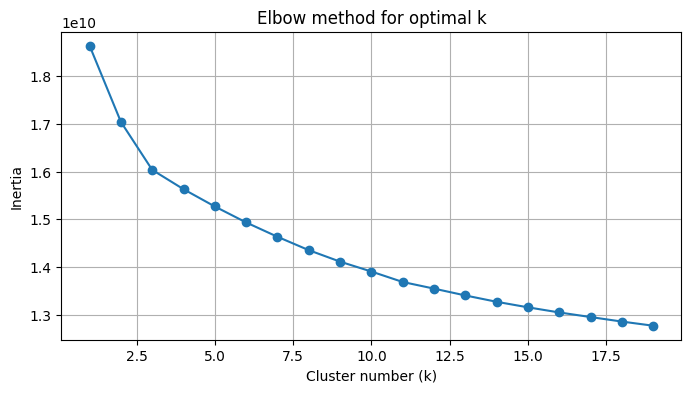

Optimal number of clusters (k): 6
Training LDA model...
LDA model trained successfully


Testing Model:   0%|          | 0/10 [00:00<?, ?it/s]

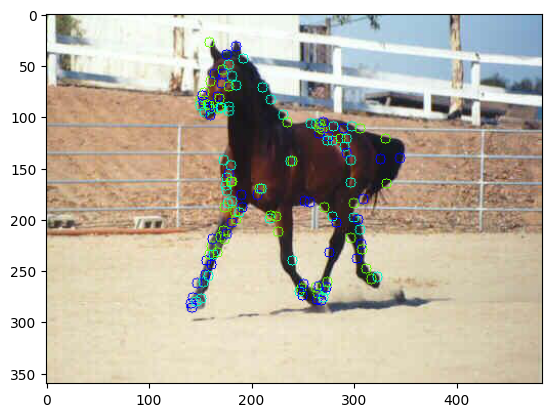

Testing Model:  10%|█         | 1/10 [00:00<00:03,  2.90it/s]

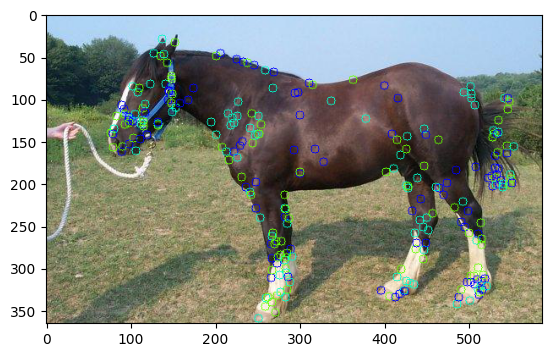

Testing Model:  20%|██        | 2/10 [00:00<00:03,  2.59it/s]

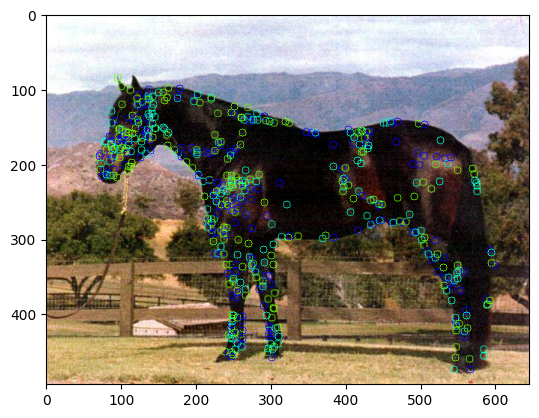

Testing Model:  30%|███       | 3/10 [00:01<00:03,  2.20it/s]

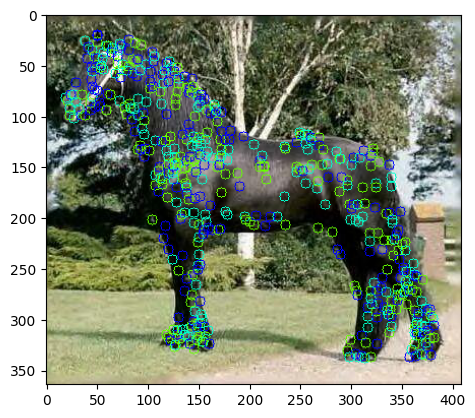

Testing Model:  40%|████      | 4/10 [00:01<00:02,  2.07it/s]

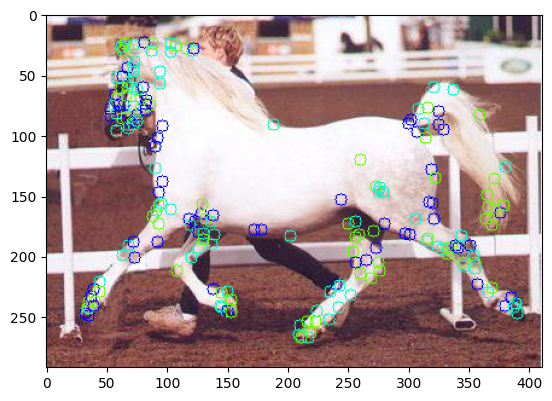

Testing Model:  50%|█████     | 5/10 [00:02<00:02,  2.14it/s]

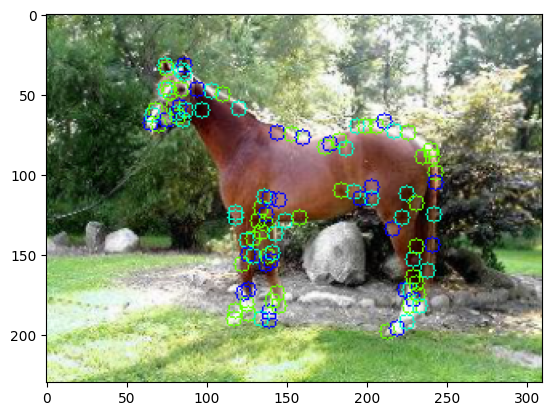

Testing Model:  60%|██████    | 6/10 [00:02<00:01,  2.25it/s]

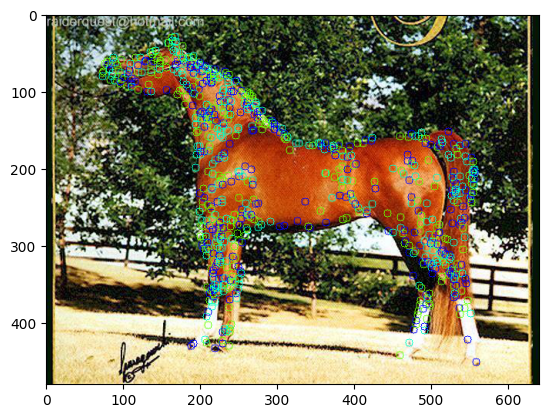

Testing Model:  70%|███████   | 7/10 [00:03<00:01,  2.02it/s]

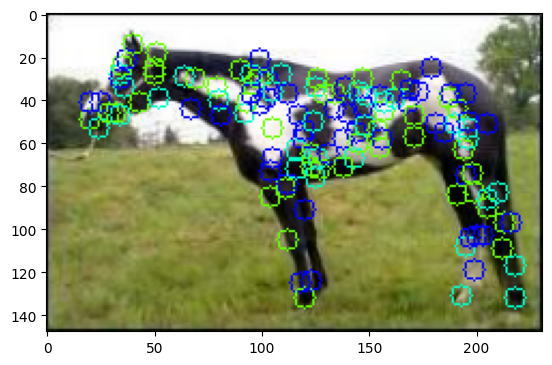

Testing Model:  80%|████████  | 8/10 [00:03<00:00,  2.16it/s]

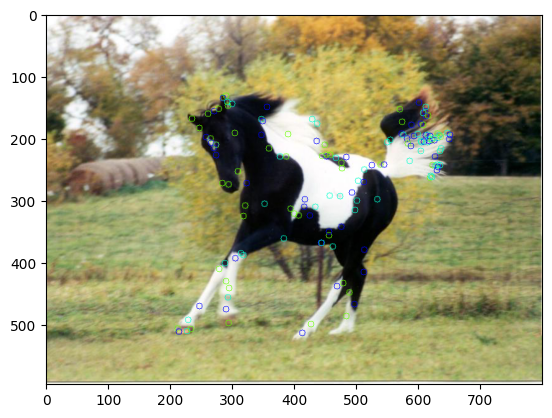

Testing Model:  90%|█████████ | 9/10 [00:04<00:00,  2.11it/s]

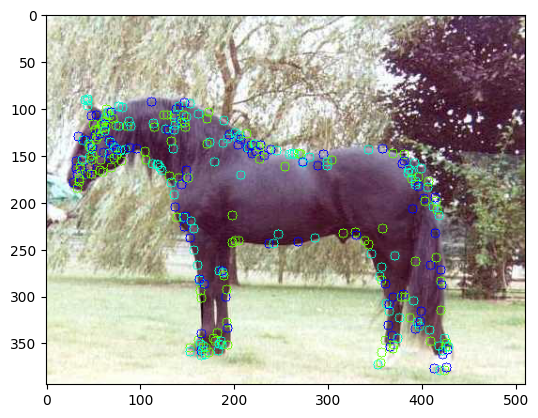

Testing Model: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


In [ ]:

def run():
    # Preparation for splitting data into training and test sets
    # Retrieve image and mask paths from the dataset directories.
    image_paths, mask_paths = get_image_and_mask_paths()
    # Split the image and mask paths into training and test sets, specifying 10 items for the test set.
    image_paths_train, image_paths_test, mask_paths_train, mask_paths_test = train_test_split(image_paths, mask_paths, test_size=10, random_state=0)
    # Load the descriptors, images, and keypoints for the training set.
    descriptors_list_train, _, _= get_descriptors(image_paths_train, mask_paths_train)
    # Train the model on the training set.
    # Cluster the descriptors using k-means to create a codebook and a trained k-means model.
    codebook, kmeans = k_means(descriptors_list_train)
    # Convert descriptors of each image to a Bag of Words representation using the trained codebook and k-means model.
    bows_train = [image_to_bow(desc, codebook, kmeans) for desc in descriptors_list_train]
    # Train the LDA model using the Bag of Words representations.
    lda_model, dictionary = train_model(bows_train)
    # For testing the model on the test set:
    # Load the descriptors, images, and keypoints for the test set.
    descriptors_list_test, images_list_test, keypoints_list_test = get_descriptors(image_paths_test, mask_paths_test)
    # Convert descriptors of each test image to a Bag of Words using the same codebook and k-means model.
    # Visualize topics on each test image based on keypoints and LDA model analysis.
    for i, image in enumerate(tqdm(images_list_test, desc="Testing Model")):
        visualize_topics(image, keypoints_list_test[i], descriptors_list_test[i], lda_model, dictionary, codebook, kmeans)

run()

# Analysis

### Masks and SIFT
The methodologies I adopted for image processing and feature extraction use a combination of segmentation masks and the SIFT (Scale-Invariant Feature Transform) algorithm.

In detail, the get_image_and_mask_paths() function retrieves the paths of images and their corresponding segmentation masks from our dataset. These masks serve to limit the area of interest during feature extraction.

In the get_descriptors() function, I use SIFT for the simultaneous extraction of keypoints and their descriptors. This procedure aims to limit the analysis solely to the subject, eliminating background distractions. During the loop that processes each image-mask pair, I convert the images to grayscale and apply the SIFT detectAndCompute method. The results, namely the keypoints and descriptors, are accumulated in dedicated lists for subsequent analysis.

### Elbow Method for Determining the Optimal Number of K
I implemented the elbow method to determine the optimal number of clusters, k, in the context of K-means cluster analysis. The displayed graph represents inertia, i.e., the sum of squared distances of examples from their nearest cluster centers, against the chosen number of clusters.

The function calculates the inertia for each k and identifies the optimal point by calculating the perpendicular distance from points on the curve to a line that connects the first and last points of the inertia. This indicates an optimal compromise between model complexity and accuracy.

The k corresponding to the maximum distance is considered the optimal number of clusters, which in this case is 6.

 ### K-MEANS
I used the K-means algorithm to cluster image descriptors in order to create a visual word code, which was used to convert images into a Bag of Words (BoW) representation. This representation is then used as input for training a Latent Dirichlet Allocation (LDA) model for topic analysis.

### LDA Model Training
Each document is modeled as a mixture of different topics, and each topic is characterized by a distribution of words. For our case, we consider each BoW as a "document" and each visual word as a "word" within that document. I trained the LDA on these data by converting BoW vectors into a format compatible with Gensim and setting the number of topics to 5, which is the number of topics the model will search for in the image.

### Plotting the Results
During the visualization phase, I iterate through each keypoint in the image. For each keypoint, I determine the most probable topic associated with its corresponding cluster.  I use a color-coding system to represent different topics, each topic is assigned a unique color. I then draw a colored circle around each keypoint using the color that corresponds to the topic of the cluster in order to highlights the salient points of the image that contribute most to the predominant topic (for example, with a blue circle) and also visually identifies the variety and distribution of topics within the image.

### Test Image Analysis
From the test images, we can observe the colored circles that indicate specific locations where the algorithm detected distinctive features used to analyze and interpret the images.

In most cases, the keypoints are predominantly concentrated on the heads and legs of the horses, with fewer markings on the rest of the body, suggesting that these areas have traits that are more easily recognized by the algorithm. It is particularly interesting to observe how the algorithm tends to identify numerous points in the blue and green topics.

Additionally, some images show a more homogeneous distribution of keypoints covering the entire body of the horse, including the head, torso, and legs. This could indicate that the algorithm is capable of identifying a wider range of distinctive features across the entire image

# Considerations
From the analysis of the images, I have understood the effectiveness of these methodologies in detecting and isolating relevant features within the images.

The use of the "elbow method" to define the optimal number of clusters K for the K-means algorithm allowed me to effectively balance the complexity of the model with the accuracy of clustering, choosing a number of clusters that reflects good data aggregation without overfitting the model.

The application of K-means to group image descriptors, followed by the training of the LDA model, transforms these visual features into analyzable data for topic extraction. The chosen number of topics (5) was sufficient to cover the breadth and variety of relevant visual features in the analyzed images (position, color, spots, tail, etc.).

The visualization of results using color-coded circles on the most significant keypoints enables a visual interpretation of how the algorithm processes the images, providing insights into how the algorithm interacts with different topics, textures, and contours.